In [1]:
import math
from draw_graph import *

In [11]:

class Value:
    def __init__(self, val, _parents=(), _op='', _label='value'):
        
        self.val = val
        self._prev = set(_parents)
        self._op = _op
        self.grad = 0.0
        self._label = _label
        self._backward = lambda: None

    def __repr__(self):
        return f"Value(val={self.val}, label={self._label})"

    def __add__(self, another_value):
        #Make sure we manipulate with Value instances
        another_value = another_value if isinstance(another_value, Value) else Value(another_value)
        
        
        #We need to accumulate gradients
        #It fixex the problem when we overwrite grad
        #when this node is used multiple times
        result = self.val + another_value.val
        out = Value(result, _parents=(self, another_value), _op='+')
        
        #Define function for backprop for sum
        def _backward():
            
            self.grad += out.grad
            another_value.grad += out.grad
        
        self._backward = _backward
        
        
        return out
    
    
    def __neg__(self):
        return self * (-1)
    
    def __sub__(self, another_value):
        return self + (-another_value)
    
    
    def __truediv__(self, another_value):
        return self * another_value ** -1
    
    def __mul__(self, another_value):
        #Make sure we manipulate with Value instances
        another_value = another_value if isinstance(another_value, Value) else Value(another_value)
                
        result = self.val * another_value.val
        out = Value(result, _parents=(self, another_value), _op='*')
        
        def _backward():
            self.grad += another_value.val * out.grad
            another_value.grad += self.val * out.grad
            
        self._backward = _backward
    
        return out
    
    def __rmul__(self, another_value):
        return self * another_value
    
    
    def tanh(self):
        val = (math.exp(2 * self.val) - 1) / (math.exp(2 * self.val) + 1)
        
        out = Value(val, _parents=(self, ), _op='tanh')
        
        def _backward():
            self.grad +=  (1 - out.val ** 2) * out.grad
            
        self._backward = _backward
        
        return out
    
    
    def __pow__(self, another_value):
        assert isinstance(another_value, (int, float)), "only int or float expected"
        
        out = Value(self.val ** another_value, _parents=(self, ), _op=f"^{another_value}")
        
        def _backward():
            self.grad = another_value * self.val ** (another_value - 1) * out.grad
            
        self._backward = _backward
        
        
        return out
        
    
    
    def exp(self):
        
        result = math.exp(self.val)
        out = Value(result, _parents=(self,), _op="exp")
        
        def _backward():
            self.grad += result * out.grad
            
        self._backward = _backward
        return out
    
    
    def backward(self):
        
        self.grad = 1
        
        topo = []
        visited = set()

        #Topological sorting
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for parent in v._prev:
                    build_topo(parent)
                topo.append(v)
         
        build_topo(self)
        
        #go through node and call _backward()
        for node in reversed(topo):
            node._backward()


In [22]:




w1 = Value(-3, _label="w1")
x1 = Value(2, _label="x1")

w2 = Value(1, _label="w2")
x2 = Value(0, _label="x1")

b = Value(6.88137)

x1w1 = x1 * w1
x2w2 = x2 * w2

together = x1w1 + x2w2

n = together + b
fin = n.tanh()

# e_z = (z*2).exp()
# tanh_fin = (e_z - 1) / (e_z + 1)

fin.backward()

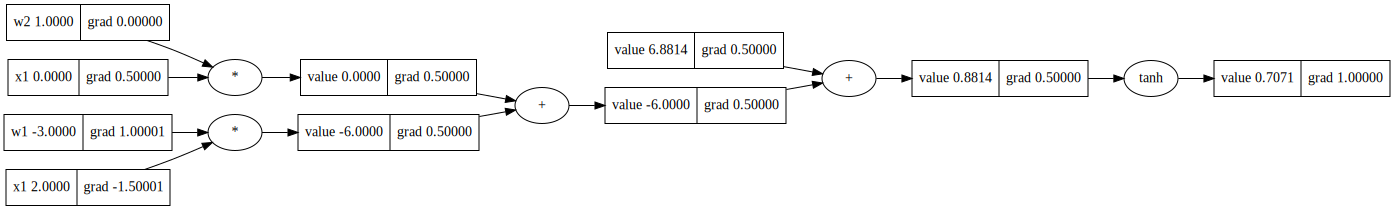

In [23]:
draw_dot(fin)